# 230518_causal_tracing_activations_v4


# Import libraries

In [6]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer, set_seed
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

# Config

In [7]:
torch.manual_seed(718)
set_seed(718)

In [ ]:
# ROME
# - localisation: pre-trained LM을 대상으로 지식 정보가 담겨있는 모듈을 찾아냄
# - ROME: 해당 부분에 적합한 

# 내가 만들고 싶은 model editing은 fine-tuning을 대체할 수 있는 방법이었음

In [8]:
dataset_nm = "Religion_and_belief_systems"
# dataset_path = f"../m2d2/dataset/{dataset_nm}/train.txt"
cache_dir="/rds/general/user/jj1122/ephemeral/.cache/huggingface"

In [9]:
device_id = 'cuda'
tuned_model_path = "../m2d2/dataset/Religion_and_belief_systems/models/"
n_layers = 12
list_modules = ['attn', 'mlp']
trace_module_id = "transformer.h.{l}.{m}"

In [10]:
list_trace_module_ids = []

for l in range(n_layers):
    for m in list_modules:
        list_trace_module_ids.append(trace_module_id.format(l=l, m=m))

print(list_trace_module_ids[:3])

['transformer.h.0.attn', 'transformer.h.0.mlp', 'transformer.h.1.attn']


# Model

## load models

In [11]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", cache_dir=cache_dir)
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)


In [230]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device_id)
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

In [417]:
# diff_weights = {}
# for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):
#     diff_weights[tuned_tup[0]] = torch.abs(tuned_tup[1] - base_tup[1]).mean().item()
    
# diff_weights

# Data

In [418]:
dataset = load_dataset("machelreid/m2d2", dataset_nm, cache_dir=cache_dir)

Found cached dataset m2d2 (/rds/general/user/jj1122/ephemeral/.cache/huggingface/machelreid___m2d2/Religion_and_belief_systems/0.0.0/eb235f33a5de3163c10549b7f63c906910539c8a8c0ec5ade1285ccbf5067d00)
100%|██████████| 3/3 [00:00<00:00, 248.56it/s]


In [419]:
np.random.seed(718)

x = 10 * np.random.randint(100000)

dataset['train']['text'][x:x+10]

['',
 'Don Edward Beck (born 1937) is a teacher, geopolitical advisor, and theorist focusing on applications of large scale psychology, including social psychology, evolutionary psychology, organizational psychology and their effect on human sociocultural systems. He is the co-author of the Spiral Dynamics theory, an evolutionary human development model adapted from the work of his mentor and colleague, developmental psychologist Clare W. Graves, Professor Emeritus in Psychology at Union College in New York, with whom he worked for over a decade.',
 'Education and academia.',
 'Beck received a B.A from Abilene Christian College in 1958 and his M.A in Theology and Communication from the same institution a year later in 1959. He was awarded his Ph.D. in Communication and Social Psychology with a focus on large scale systems dynamics and change in 1966 by the University of Oklahoma. His dissertation was on the psychological forces that produced the American Civil War.',
 'Beck has held po

In [632]:
# input_text = "He was a religious scholar and a prolific writer. Many of his works are used as references for church members"

# input_text = "In popular and media culture, Anubis is often falsely portrayed as the sinister god of the dead"

# input_text = "Ankou appears as a man or skeleton wearing a black robe and a large hat which conceals his face, or, on occasion, simply as a shadow"

# input_text = "Zechariah's vision of recently deceased Joshua the High Priest depicts a dispute in the heavenly throne room between Satan and the Angel of the Lord"

input_text = "The Transcendental Argument for the Existence of God (TAG) is the argument that attempts to prove the existence of God by arguing that logic, morals, and science ultimately presuppose a supreme being and that God must therefore be the source of logic and morals"


In [633]:
inputs = gpt2_tokenizer(input_text, return_tensors="pt").to(device_id)
n_tokens = inputs['input_ids'].shape[1]
n_tokens

52

In [634]:
list_input_text = gpt2_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

for idx in range(1, n_tokens):
    if not list_input_text[idx].startswith("Ġ"):
        list_input_text[idx-1] = list_input_text[idx-1] + "##"
    list_input_text[idx] = list_input_text[idx].replace("Ġ", "")

# Main

## first run - clean

### register hook - save_clean_activation

In [635]:
def save_clean_activation(m_id):
    def save_clean_activation_hook(module, _input, _output):
#         print(m_id, _output.shape)
        if m_id.endswith('attn'):
            clean_activations[m_id] = _output[0].detach()
        elif m_id.endswith('mlp'):
#         else:
            clean_activations[m_id] = _output.detach()
    return save_clean_activation_hook

In [636]:
clean_activations = {}

tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

for m_id in list_trace_module_ids:
    tuned_model.get_submodule(m_id).register_forward_hook(save_clean_activation(m_id))

### get clean_activations & clean_loss

In [637]:
with torch.no_grad():
    tuned_model.eval()
    clean_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)    
    clean_loss = np.exp(clean_outputs.loss.item())
clean_loss

13.573352837326823

## second run - corruped

### register hook - corrupt_input_vector

In [638]:
def corrupt_input_vector(module, _input):#, _output):
    torch.manual_seed(718)
#     print(module, _input)
#     print(_input)
    std = torch.std(_input[0])
    return tuple([_input[0] + (std*1.5) * torch.randn(_input[0].shape).to(device_id), ])

In [639]:
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

tuned_model.get_submodule("transformer.h.0.attn").register_forward_pre_hook(corrupt_input_vector)

### get corrupt_input_vector & corrupted_loss

In [640]:

with torch.no_grad():
    torch.manual_seed(718)
    tuned_model.eval()
    corrupted_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
    corrupted_loss = np.exp(corrupted_outputs.loss.item())
corrupted_loss    

18.395775714257592

## Thrid run - corrupted-with-restoration run

### register hook - restore_activation & restored losses

In [641]:
def restore_activation(m_id):
    def restore_activation_hook(module, _input, _output):
        clean_activation = clean_activations[m_id]#[:, t]
        if m_id.endswith('attn'):
#             corrupted_activation = _output[0].detach()
#             base_output[:, t] = tuned_output
#             corrupted_activation = clean_activation
            return tuple([clean_activation, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):           
            base_output = _output.detach()
#             base_output[:, t] = tuned_output
            base_output = clean_activation
            return base_output
    return restore_activation_hook

In [642]:
restored_loss = {}
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

with torch.no_grad():
    tuned_model.eval()
    tuned_model.get_submodule("transformer.h.0.attn").register_forward_pre_hook(corrupt_input_vector)
    for m_id in list_trace_module_ids:
#         for t in range(n_tokens):
        hook = tuned_model.get_submodule(m_id).register_forward_hook(restore_activation(m_id))
        restored_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
        restored_loss[m_id] = np.exp(restored_outputs.loss.item())
        hook.remove()
        

In [643]:
list(restored_loss.items())[:10]

[('transformer.h.0.attn', 13.573352837326823),
 ('transformer.h.0.mlp', 14.274880534457854),
 ('transformer.h.1.attn', 21.543103091989984),
 ('transformer.h.1.mlp', 20.8595076933879),
 ('transformer.h.2.attn', 17.51346675330437),
 ('transformer.h.2.mlp', 18.091306491554267),
 ('transformer.h.3.attn', 16.443810897114936),
 ('transformer.h.3.mlp', 16.982345444060076),
 ('transformer.h.4.attn', 17.352509155673943),
 ('transformer.h.4.mlp', 18.33990111156065)]

## Losses

In [644]:
clean_loss, corrupted_loss, np.mean(list(restored_loss.values()))

(13.573352837326823, 18.395775714257592, 17.73122174651327)

In [645]:
# TE = (base_loss - tuned_loss) / base_loss
# IDE = {}
# for m_id in list_trace_module_ids:
#     for t in range(n_tokens):
#         IDE[m_id + f'.{t}'] = restored_loss[m_id + f'.{t}'] / base_loss
        
TE = (corrupted_loss - clean_loss) / clean_loss
IDE = {}
for m_id in list_trace_module_ids:
    IDE[m_id] = (restored_loss[m_id] - clean_loss) / clean_loss

In [646]:
def parse_code(row):
    list_code = row.code.split(".")
    row['l'] = int(list_code[2])
    row['m'] = list_code[3]
#     row['t'] = int(list_code[4])
    return row

df_ide = pd.DataFrame.from_dict(IDE, orient='index').reset_index()
df_ide.columns = ['code', 'ide']
df_ide = df_ide.apply(lambda row: parse_code(row), axis=1)
# df_ide['token'] = df_ide['t'].apply(lambda x: list_input_text[int(x)])

## Results

##### He was a religious scholar and a prolific writer. Many of his works are used as references for church members

<Axes: xlabel='None-l', ylabel='m'>

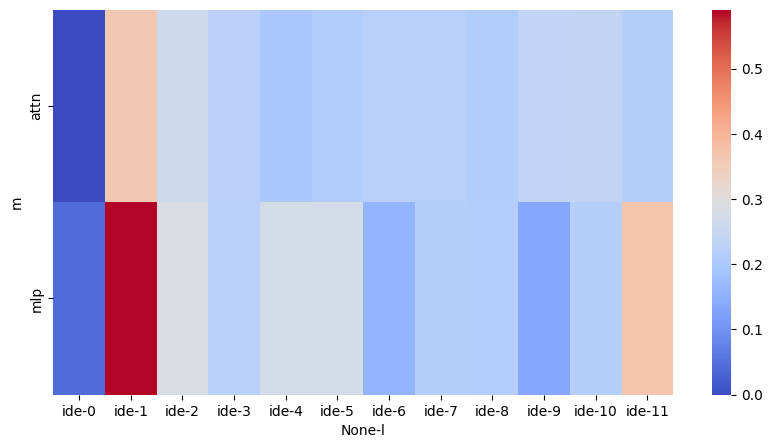

In [583]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=0.3, vmin=0
)

##### 'In popular and media culture, Anubis is often falsely portrayed as the sinister god of the dead'


<Axes: xlabel='None-l', ylabel='m'>

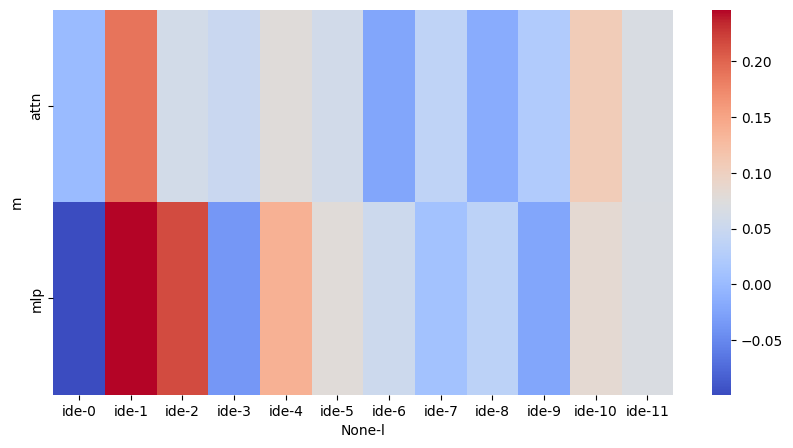

In [599]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### Elderly people often have limited regenerative abilities and are more susceptible to disease, syndromes, injuries and sickness than younger adults.

<Axes: xlabel='None-l', ylabel='m'>

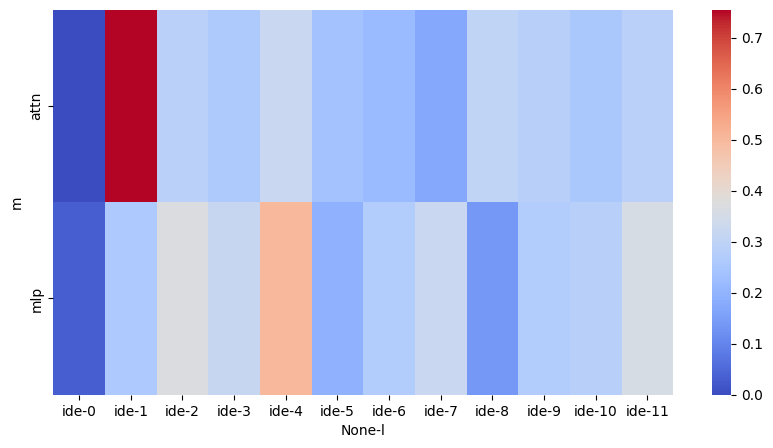

In [615]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### "Zechariah's vision of recently deceased Joshua the High Priest depicts a dispute in the heavenly throne room between Satan and the Angel of the Lord"


<Axes: xlabel='None-l', ylabel='m'>

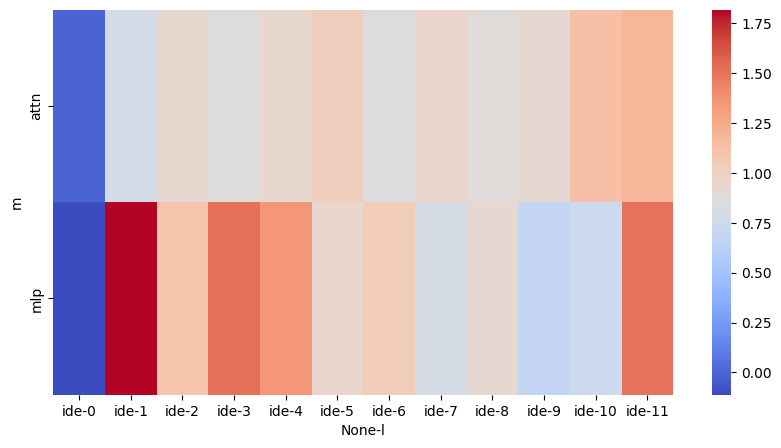

In [631]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### The Transcendental Argument for the Existence of God (TAG) is the argument that attempts to prove the existence of God by arguing that logic, morals, and science ultimately presuppose a supreme being and that God must therefore be the source of logic and morals

<Axes: xlabel='None-l', ylabel='m'>

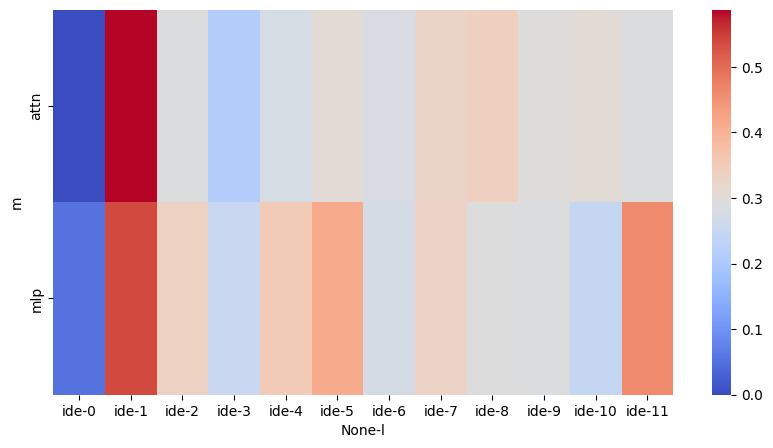

In [647]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

### Conclusion
- When restore MLP activation, the model shows better result
- but the layer order doesn't show any pattern.

### Questions
- Q1) Multiple models in casual tracing?: I guess because of other weight differences between base and fine-tuned models despite the restored activations, the restoration wouldn’t work properly. The restored values from the tuned model would be re-changed by the weights and baises in the base model.
- Q2) Constraint on dataset: they used **triples (subject, relation, object)**, and as far as I understand, they constrained the templates which they build. Most **subject tokens** appear in the heads of templates and **object** appear in the back to track the result efficiently. Do we need to constrain dataset too?
